C:\Users\Venkat Raman\AppData\Local\Temp\ipykernel_46492\2702637732.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M1 = float((E_LDA.T @ M1).real)
C:\Users\Venkat Raman\AppData\Local\Temp\ipykernel_46492\2702637732.py:114: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M2 = float((E_LDA.T @ M2).real)


Accuracy of LDA plus NCC Classifier: 99


C:\Adithya\Anaconda\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Adithya\Anaconda\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


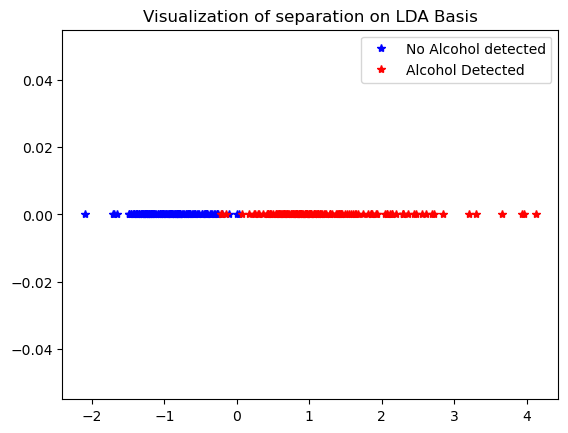

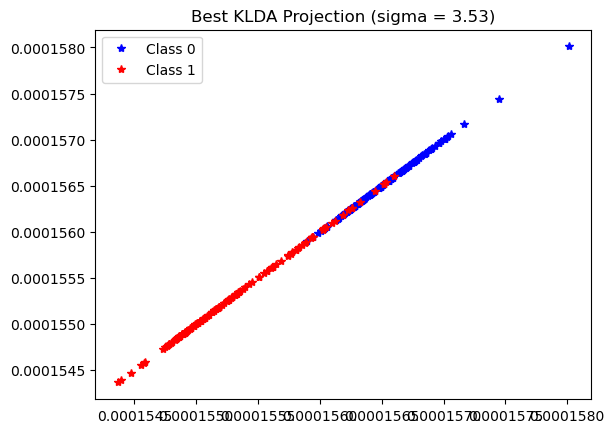

Accuracy using KLDA: 98.0


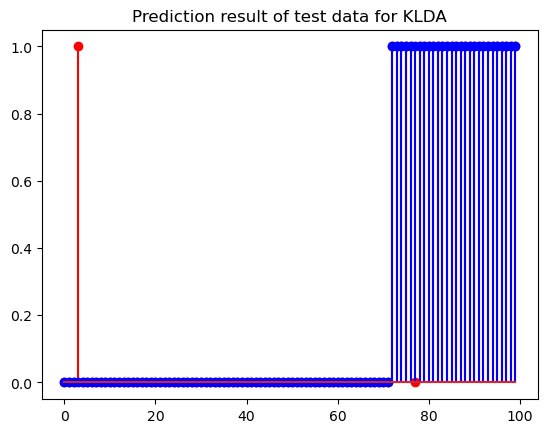

In [31]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eig, inv, pinv,eigh,norm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
np.random.seed(0)
#LDA attempt
def LDA(TRAINDATA1,TRAINDATA2):
    
    # Calculation of means
    MEAN1 = np.mean(TRAINDATA1, axis=1)
    MEAN2 = np.mean(TRAINDATA2, axis=1)
    
    # Construction of Between-class scatter matrix
    C=(MEAN1+MEAN2)/2
    M1 = MEAN1[:, np.newaxis]  # shape (2,1)
    M2 = MEAN2[:, np.newaxis]
    C = C[:, np.newaxis]       # shape (2,1)
    SB= 145*((((M1-C) @ (M1-C).T) + ((M2-C) @ (M2-C).T)))
    
    # Construction of Within-class scatter matrix
    SW = 145*(((TRAINDATA1 - M1) @ (TRAINDATA1 - M1).T +
          (TRAINDATA2 - M2) @ (TRAINDATA2 - M2).T))
    # Solving the LDA eigenvalue problem
    eigvals, E = eig(pinv(SW) @ SB)
    
    # Sorting the Eigvalues/vectors in descending order of magnitude
    sorted_indices = np.argsort(eigvals)[::-1]
    E=E[:,sorted_indices[:1]]
    # print(E) #To understand and verify how much each original feature contributed

    #Visualization of distinction
    T1=E.T @ TRAINDATA1
    T2=E.T @ TRAINDATA2
    plt.figure()
    plt.plot(T1.flatten(),np.zeros_like(T1.flatten()),'b*',label='No Alcohol detected')
    plt.plot(T2.flatten(),np.zeros_like(T2.flatten()),'r*',label='Alcohol Detected')
    plt.legend()
    plt.title("Visualization of separation on LDA Basis")
    return E,M1,M2

#LOADING DATASET
df = pd.read_csv(r"C:\Users\Venkat Raman\Downloads\Driver_Alcohol_Test - Copy.csv")

#DATA INSIGHTS
#df.describe()
# sns.boxplot(data=df[['TEMP_FAC_MIN', 'EYES']])  # replace with actual names
# plt.show()
for col in ['EYES', 'TEMP_FAC_MIN']:
    median = df[col].median()
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    df.loc[outliers, col] = median
df.describe()

# #Visualizing features individually
# df.hist(bins=20, figsize=(10, 8))
# plt.show()

# #Visualizing Corellation and interdependence
corr = df.corr()
#sns.heatmap(corr, annot=True, cmap='coolwarm')
# sns.pairplot(df)

#Centering about mean and making std 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('LABEL', axis=1))
X_scaled=np.array(X_scaled)
X_scaled=X_scaled.T


#EXTRACTING TARGET OUTPUT
t=df['LABEL']
t=t-1
t=np.array(t)
t.resize(390,1)

#TRAIN TEST SPLIT
perm1 = np.random.permutation(217)
perm2 = np.random.permutation(173)

TRAINIDX1 = perm1[:145]
TESTIDX1 = perm1[145:]

TRAINIDX2 = perm2[:145]
TESTIDX2 = perm2[145:]


# Offset class 2 indices since they start at column 217
TRAINIDX2 += 217
TESTIDX2 += 217


# Extract data from X_scaled
TRAINDATA1 = X_scaled[:, TRAINIDX1]  
TRAINDATA2 = X_scaled[:, TRAINIDX2]  
TRAIN_TARGET1 = t[TRAINIDX1]
TRAIN_TARGET2 = t[TRAINIDX2]

TESTDATA1 = X_scaled[:, TESTIDX1]    
TESTDATA2 = X_scaled[:, TESTIDX2]    
TEST_TARGET1 = t[TESTIDX1]
TEST_TARGET2 = t[TESTIDX2]

# LDA
E_LDA,M1,M2=LDA(TRAINDATA1,TRAINDATA2)
Y1=(E_LDA.T @ TESTDATA1).flatten()
Y2=(E_LDA.T @ TESTDATA2).flatten()
M1 = float((E_LDA.T @ M1).real)
M2 = float((E_LDA.T @ M2).real)

# Classifying using nearest centroid
centroids = [M1,M2]
PRED1 = []
PRED2 = []
PRED1 = [np.argmin([abs(y - c) for c in centroids]) for y in Y1]
PRED2 = [np.argmin([abs(y - c) for c in centroids]) for y in Y2]
PRED=np.concatenate((PRED1,PRED2))
TRAIN_TARGET= np.concatenate((TRAIN_TARGET1.flatten(),TRAIN_TARGET2.flatten()))
TEST_TARGET= np.concatenate((TEST_TARGET1.flatten(),TEST_TARGET2.flatten()))
acc=0
for i in range(100):
    if(PRED[i]==TEST_TARGET[i]):
        acc+=1
print("Accuracy of LDA plus NCC Classifier:",acc)
def gausskernel(x, y, sigma):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def KLDA(TRAINDATA1, TRAINDATA2, TESTDATA1, TESTDATA2, TRAIN_TARGET, TEST_TARGET):
    TRAINDATA = np.hstack((TRAINDATA1, TRAINDATA2))
    TESTDATA = np.hstack((TESTDATA1, TESTDATA2))

    labels_train = TRAIN_TARGET
    labels_test = TEST_TARGET

    sigma_list = np.linspace(0.5,5,50)
    best_acc = 0
    best_sigma = None
    best_E = None
    best_train_proj = None
    best_test_proj = None
    best_pred_labels= None
    for sigma in sigma_list:
        # Gram matrix for training data
        G = np.zeros((TRAINDATA.shape[1],TRAINDATA.shape[1]))
        for i in range(TRAINDATA.shape[1]):
            for j in range(TRAINDATA.shape[1]):
                G[i, j] = gausskernel(TRAINDATA[:, i], TRAINDATA[:, j], sigma)

        # Splitting Gram matrix class-wise for SB  and SW formation
        X1_kernel = G[:, :145]
        X2_kernel = G[:, 145:]

        
        # Class-wise mean vectors
        M1 = np.mean(X1_kernel, axis=1, keepdims=True)
        M2 = np.mean(X2_kernel, axis=1, keepdims=True)
        C = (M1 + M2 ) / 2

        # Scatter matrices
        SB = 145 * ((M1 - C) @ (M1 - C).T + (M2 - C) @ (M2 - C).T)
        SW = 145 * ((X1_kernel - M1) @ (X1_kernel - M1).T +
                   (X2_kernel - M2) @ (X2_kernel - M2).T)

        # Solving the eigen value problem
        eigvals, eigvecs = eig(pinv(SW) @ SB)
        idx = np.argsort(eigvals)[::-1]
        E = eigvecs[:, idx[:2]]

        # Projecting training data
        Y1 = E.T @ X1_kernel
        Y2 = E.T @ X2_kernel
        Y_train = np.hstack((Y1, Y2)).T

        # Centroids
        centroids = [np.mean(Y_train[labels_train == i], axis=0) for i in range(2)]

        # Project test data
        Y_test = []
        for i in range(TESTDATA.shape[1]):
            k = [gausskernel(TESTDATA[:, i], TRAINDATA[:, j], sigma) for j in range(TRAINDATA.shape[1])]
            proj = E.T @ np.array(k)
            Y_test.append(proj)
        Y_test = np.array(Y_test)
        
        # Classify using nearest centroid
        pred_labels = []
        for y in Y_test:
            dists = [np.linalg.norm(y - c) for c in centroids]
            pred_labels.append(np.argmin(dists))
        pred_labels=np.array(pred_labels)
        acc = np.mean(pred_labels == labels_test) * 100

        # Keep best
        if acc > best_acc:
            best_acc = acc
            best_sigma = sigma
            best_E = E
            best_train_proj = (Y1, Y2)
            best_test_proj = Y_test
            best_pred_labels= pred_labels
    # Vizualisation of separation on KLDA basis for training data
    Y1, Y2 = best_train_proj
    plt.figure()
    plt.plot(Y1[0], Y1[1], 'b*', label='Class 0')
    plt.plot(Y2[0], Y2[1], 'r*', label='Class 1')
    plt.legend()
    plt.title(f"Best KLDA Projection (sigma = {best_sigma:.2f})")
    plt.show()
    #Test Predictions
    plt.figure()
    plt.stem(best_pred_labels,'r-')
    plt.stem(labels_test,'b-')
    plt.title("Prediction result of test data for KLDA")
    print("Accuracy using KLDA:",best_acc)
KLDA(TRAINDATA1, TRAINDATA2, TESTDATA1, TESTDATA2, TRAIN_TARGET, TEST_TARGET)